In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline
from bs4 import BeautifulSoup
import urllib
import re
from scipy.stats import mode
from datetime import timedelta
from math import modf
from sklearn.preprocessing import PolynomialFeatures

sns.set()

pd.set_option('display.max_rows', 450)  # показывать больше строк
pd.set_option('display.max_columns', 150)  # показывать больше колонок

Выгружаем датасет в переменную df

In [2]:
df = pd.read_csv('main_task.csv')

Смотрим на количество пропусков в данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Распарсим данные с сайта для столбца диапазона цен

In [ ]:
def fill_price_range(row):

    if pd.isnull(row['Price Range']):
        try:
            url = 'https://www.tripadvisor.ru' + row['URL_TA']
            html_doc = urllib.request.urlopen(url).read()
            soup = BeautifulSoup(html_doc)
        except:
            row['Price Range'] = 'no data'
            return row

        try:
            parsed_html = str(soup.find_all('div', '_1ud-0ITN')[0])
            pattern = re.compile('[$]{1,3}\s?-?\s?[$]*')
            text = re.findall(pattern, parsed_html)
        except:
            pass
        try:
            row['Price Range'] = text[0]
        except:
            row['Price Range'] = 'no data'

    return row


df = df.apply(fill_price_range, axis=1)

In [3]:
df.loc[:, 'Price Range'] = df['Price Range'].map({
    'no data': 0,
    '$$ - $$$': 2,
    '$': 1,
    '$$$$': 3
})
#df.to_csv('main_parsed_data.csv')

Чтобы каждый раз не парсить сайт, сохраняем частично заполненный датасет в файле main_parsed_data.csv

In [18]:
df = pd.read_csv('main_parsed_data.csv', index_col=0)

In [19]:
display(df.info())
display(df['Price Range'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        40000 non-null  int64  
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 3.4+ MB


None

2    22039
1     8961
0     7454
3     1546
Name: Price Range, dtype: int64

В результате парсинга удалось заполнить примерно половину всех значений

Возьмем с сайта информацию об общем количестве ресторанов по городам

In [6]:
cities = df.City.unique()

In [7]:
restaurant_number = {}
for city in cities:
    url = 'https://www.tripadvisor.ru' + df[df.City == city].URL_TA.iloc[0]
    html_doc = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html_doc)
    try:
        try:
            parsed_html = str(soup.find_all('div', '_3-W4EexF')[1])
        except:
            parsed_html = str(soup.find_all('div', '_3-W4EexF')[0])
    except:
        restaurant_number[city] = None
        continue
    pattern = re.compile('из \d*\s?\d*')
    text = re.findall(pattern, parsed_html)[0]
    pattern = re.compile('\d+')
    text = re.findall(pattern, text)
    text = int(''.join(text))
    restaurant_number[city] = text

Дозаполним ошибочную информацию с сайта вручную

In [8]:
restaurant_number['Amsterdam'] = 3625
restaurant_number['Budapest'] = 2720
restaurant_number['Lisbon'] = 4417
restaurant_number['Brussels'] = 2356

In [23]:
#df.to_csv('new_parsed_data.csv')

In [24]:
df = pd.read_csv('new_parsed_data.csv', index_col=0)

Так как городов всего 31, заполним вручную статистические показатели о населении городов

In [ ]:
city_information = {}
for city in cities:
    print(city)
    population_density = input('Введите данные о плотности населения:')
    population_number = input('Введите численность населения:')
    city_information[city] = [population_density, population_number]

Paris


Эту информацию также следует сохранить в файл, чтобы каждый раз не вводить значения вручную

In [ ]:
#city_information.to_csv('city_information.csv')

In [9]:
city_information = pd.read_csv('city_information.csv', index_col=0)

Перенесем информацию в датасет

In [10]:
df.loc[:, 'Population Density'] = 0
df.loc[:, 'Population Number'] = 0


def create_population_features(row):
    row['Population Density'] = city_information.loc[row['City'],
                                                     'population_density']
    row['Population Number'] = city_information.loc[row['City'],
                                                    'population_number']
    return row


df = df.apply(create_population_features, axis=1)

Нормализуем столбец численности населения в городах и приравняем слишком большие значения к единице

In [11]:
max_population_number = df['Population Number'][
    df['Population Number'] < df['Population Number'].max()].max()


def normalize_number_of_population(row):
    global max_population_number
    row['Population Number'] = row['Population Number'] / max_population_number
    if row['Population Number'] > 1:
        row['Population Number'] = 1
    return row


df = df.apply(normalize_number_of_population, axis=1)

Эти же манипуляции проделываем и со столбцом плотности начеления

In [12]:
max_population_density = df['Population Density'][
    df['Population Density'] < df['Population Density'].max()].max()


def normalize_density_of_population(row):
    global max_population_density
    row['Population Density'] = row[
        'Population Density'] / max_population_density
    if row['Population Density'] > 1:
        row['Population Density'] = 1
    return row


df = df.apply(normalize_density_of_population, axis=1)

Сделаем из строкового столбца стилей кухни Dummy-переменные

In [13]:
Cuisine_Style = df['Cuisine Style'].str.slice(1, -1)

Cuisine_Style = Cuisine_Style.fillna("'Other'")

Cuisine_Style = pd.DataFrame(
    Cuisine_Style.str.split(', ').tolist()).stack().reset_index()

Cuisine_Style.columns = ['row_index', 'row_subindex', 'style']

Cuisine_Style['style'] = Cuisine_Style['style'].str.slice(1, -1)

popular_styles = Cuisine_Style['style'].value_counts()[
    Cuisine_Style['style'].value_counts() > 1500].index

df['Cuisine Style'] = df['Cuisine Style'].fillna("Empty")

for style in popular_styles:
    df.loc[:, style] = 0


def fill_styles(row):
    other_identifier = 1
    for style in popular_styles:
        if style in row['Cuisine Style']:
            row[style] = 1
            other_identifier = 0
        if other_identifier == 1:
            row['Other'] = 1
    return row


df = df.apply(fill_styles, axis=1)

Заполним исходный столбец стилей кухни количеством стилей или пустым значением в случае пропусков

In [14]:
def transform_cuisine_style(row):
    if row['Cuisine Style'] != 'Empty':
        row['Cuisine Style'] = len(row['Cuisine Style'][1:-1].split(', '))
    else:
        row['Cuisine Style'] = np.nan

    return row


df = df.apply(transform_cuisine_style, axis=1)

Создаем библиотеку часто встречающихся положительных слов о ресторане

In [15]:
good_words = [
    'good', 'best', 'not bad', 'great', 'unique', 'nice', 'better', 'friendly',
    'amazing', 'excellent', 'clean', 'highly', 'high', 'quick', 'super',
    'wonderful', 'well', 'decent', 'tasty', 'beautiful', 'fantastic', 'ok'
]

Ищем количество положительных слов в столбце комментариев о ресторане, в случае отсутствия заполняем пустым значением

In [17]:
df.loc[:, 'Good Reviews'] = 0


def fill_good_reviews(row):
    global good_words
    count = 0
    if row['Reviews'] == '[[], []]':
        row['Reviews'] = np.nan
        return row
    for word in good_words:
        pattern = re.compile(r'\b{}\b'.format(word))
        result = re.findall(pattern, row['Reviews'].lower())
        count += len(result)
    row['Good Reviews'] = count
    return row


df = df.apply(fill_good_reviews, axis=1)

Создаем столбец категории популярности ресторана на основе данных о количестве отзывов

In [18]:
df.loc[:, 'Popular Category'] = 0


def ordinary_reviews_number(row):
    if row['Number of Reviews'] <= 7:
        row['Popular Category'] = 1
    elif row['Number of Reviews'] > 7 and row['Number of Reviews'] <= 20:
        row['Popular Category'] = 2
    elif row['Number of Reviews'] > 20 and row['Number of Reviews'] <= 53:
        row['Popular Category'] = 3
    elif row['Number of Reviews'] > 53 and row['Number of Reviews'] <= 153:
        row['Popular Category'] = 4
    elif row['Number of Reviews'] > 153:
        row['Popular Category'] = 5
    return row


df = df.apply(ordinary_reviews_number, axis=1)

Нормализуем столбец количества отзывов, приравнивая очень большие значения к единице

In [19]:
threshold_reviews_number = np.quantile(df['Number of Reviews'].dropna(), 0.995)

max_reviews_number = df[df['Number of Reviews'] <
                        threshold_reviews_number]['Number of Reviews'].max()


def normalize_number_of_reviews(row):
    global mean_reviews
    row['Number of Reviews'] = row['Number of Reviews'] / max_reviews_number
    if row['Number of Reviews'] > 1:
        row['Number of Reviews'] = 1

    return row


df = df.apply(normalize_number_of_reviews, axis=1)

Создаем столбец отношения рейтинга ресторана по городу к общему количеству ресторанов и нормализуем этот столбец 

In [20]:
df.loc[:, 'Ranking Category'] = None


def ranking_category(row):
    coef = row.Ranking / restaurant_number[row.City]
    if coef > 1:
        row['Ranking Category'] = 1
    row['Ranking Category'] = coef

    return row

In [22]:
df = df.apply(ranking_category, axis=1)

Создаем полиномиальный признак из количества отзывов и категории популярности, который в результате немного улучшит показатели итоговой модели

In [27]:
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(
    df.dropna()[['Number of Reviews', 'Popular Category']])

In [28]:
poly_features = pd.DataFrame(poly_features).iloc[:, 3]
poly_features = pd.DataFrame(poly_features)
poly_features.columns = ['PolyFeature']
df = pd.concat([df.dropna().reset_index(), poly_features], axis=1)

Из столбца города создаем Dummy-переменные

In [29]:
dummy = pd.get_dummies(df.City)
dummy = dummy.astype('int64')
df = pd.concat([df, dummy], axis=1)

Создаем столбец промежутка времени между двумя отзывами на сайте ресторана, в случае отрицательных значений берем модуль

In [30]:
df.loc[:, 'Reviews Timedelta'] = 0


def get_review_timedelta(row):
    pattern = re.compile(r'\d{2}/\d{2}/\d{4}')
    dates = re.findall(pattern, row['Reviews'])
    try:
        row['Reviews Timedelta'] = (pd.to_datetime(dates[0]) -
                                    pd.to_datetime(dates[1])).days

    except:
        row['Reviews Timedelta'] = np.nan

    return row


df = df.apply(get_review_timedelta, axis=1)
df['Reviews Timedelta'] = abs(df['Reviews Timedelta'])

Смотрим на распределение отношения рейтинга ресторана по городу к общему количеству ресторанов в городе и выбираем пороговое значение, которое в нормализованном столбце будет равно единице, как и значения изначально большие 

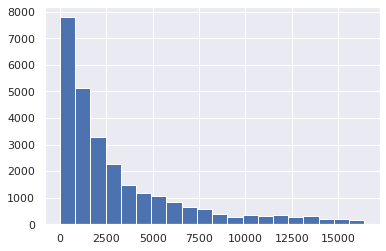

In [42]:
df['Ranking'].hist(bins=20)

In [31]:
treshhold_ranking = 7500


def normalize_ranking(row):
    row['Ranking'] = row['Ranking'] / treshhold_ranking
    if row['Ranking'] > 1:
        row['Ranking'] = 1
    return row


df = df.apply(normalize_ranking, axis=1)

Тестируем данные на модели случайного леса, избавляясь от ненужных столбцов и пустых значений, для большей точности проводим тест 10 раз и берем среднее.

Финальная версия датафрейма

In [2]:
df_train = pd.read_csv('final_version.csv', index_col=0)

Наилучшим решением оказалось убрать все строки с пустыми значениями, и строки, где категория диапазона цен равна 0. Именно после таких манипуляций с данными получался наилучший результат. Также я пробовал уменьшить количество Dummy-переменных для городов, но это также не оправдало ожидания.

In [3]:
test = df_train.copy()
test = test.drop(['Restaurant_id', 'City', 'Reviews', 'URL_TA', 'ID_TA'],
                 axis=1)
test = test.dropna()

X = test.drop(['Rating'], axis=1)
y = test['Rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.ensemble import RandomForestRegressor  # инструмент для создания и обучения модели
from sklearn import metrics  # инструменты для оценки точности модели

regr = RandomForestRegressor(n_estimators=100)

regr.fit(X_train, y_train)
y_pred = np.round(regr.predict(X_test) * 2) / 2
res = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', res)

MAE: 0.16842900302114805


В результате проделанной работы показатель метрики MAE уменьшился с 0.5 до 0.17, в результате парсинга сайта TripAdvisor удалось заполнить часть пропусков, а также добавить новые признаки. На основе изначальных признаков также удалось сделать новые, нормализовать их и заменить слишком большие значения. Добавлено 2 dummy-переменных и один полиномиальный признак. С очень большой частью данных пришлось расстаться из-за пропусков, потому что ни один из основных методов их заполнения не принес успех в работе модели.